In [1]:
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

Importo la base de datos de los pacientes, recogida en SPSS y pasada posteriormente a documento csv. Para su analisis

In [2]:
datos=pd.read_csv("Analisis_ano.csv",sep=";")

In [3]:
datos.head()

,Médico,Tipo_cápsula,Fecha_procedimiento,ID,Sexo,Nacimiento,Edad,Cintura,IMC,Tiempo_estudio,...,Patency,No_aporta_previo,Eco_abdominal,Rx_abdomen,Entero_TAC,Entero_RM,Tránsito_intes,Endoscopia_previa,Intro_cápsula,Complicaciones
0,1,1,5/14/2012,1,1,6/24/1925,86,,,,...,0,1,0,0,0,0,0,0,0,0
1,1,1,9/5/2012,2,1,1/12/1953,59,,,,...,0,1,0,0,0,0,0,0,0,0
2,1,1,10/17/2012,3,1,2/21/1951,61,,,,...,0,1,0,0,0,0,0,0,0,0
3,1,1,12/14/2013,4,1,10/1/1950,63,,,,...,0,1,0,0,0,0,0,0,0,0
4,1,1,10/25/2013,5,0,7/4/1935,78,,,,...,0,1,0,0,0,0,0,2,0,0


In [4]:
datos.shape

(251, 150)

In [5]:
datos.dtypes[:]

Médico                  int64
Tipo_cápsula            int64
Fecha_procedimiento    object
ID                      int64
Sexo                    int64
                        ...  
Entero_RM               int64
Tránsito_intes          int64
Endoscopia_previa      object
Intro_cápsula           int64
Complicaciones         object
Length: 150, dtype: object

In [6]:
columnas=datos.columns

In [7]:
incompletas=[]
for e in columnas:
    if datos[e].isnull().sum()>=1:
        incompletas.append(e)
print(incompletas)

[]


Como se ve no hay ninguna variable, con valores nulos en toda la base de datos

In [8]:
columnas=datos.columns
columnas.tolist()

['Médico',
 'Tipo_cápsula',
 'Fecha_procedimiento',
 'ID',
 'Sexo',
 'Nacimiento',
 'Edad',
 'Cintura',
 'IMC',
 'Tiempo_estudio',
 'T_estómago',
 'T_ID_total',
 'T_colon_total',
 'T_expulsión',
 'Expulsa_cápsula',
 'HDOO_oculta',
 'HDOO_mani',
 'Crohn',
 'Alt_tránsito',
 'Anemia',
 'Dolor_abd',
 'Estreñimiento',
 'Diarrea',
 'Vómitos',
 'Pérdida_peso',
 'EII',
 'Colono_imcp',
 'Cribado',
 'Revisión',
 'Otros_indica',
 'Hernia_hiato_esof',
 'RGE_esof',
 'Trast_tránsito_esof',
 'Erosiones_esof',
 'Barret_esof',
 'Esof_eosinofilica_esof',
 'Estenosis_extr_esof',
 'No_evaluable_esof',
 'No_informado_esof',
 'Normal_esof',
 'Normal_estom',
 'No_informado_estom',
 'No_evaluable_estom',
 'Hernia_hiato_estom',
 'Trast_motilidad_estom',
 'Erosiones_estom',
 'Gastritis_estom',
 'Pólipo_estom',
 'Otros_estom',
 'No_informado_del',
 'No_evaluable_del',
 'Normal_del',
 'Hz_yeyuno',
 'Yeyunitis',
 'Erosiones_yey',
 'Telangiectasias_yey',
 'Linfagiectasias_yey',
 'Pólipo_yey',
 'Hz_íleon',
 'Ileitis

In [9]:
#Borro la variable Dianoscitos porque sería un hallazgo compatible con la normalidad.
datos.drop(columns=['Dianocitos'],axis=0, inplace=True)

Uno en una única variable las hernias de hiato de esófago y estomago. Al ser el mismo diagnostico, simplemente puesto
en esófago o estomago según el momento de la cápsula en el que se diagnosticaba. Quedando unificada en la variable "Hernia_hiato_total"

In [10]:
def hernia(fila):
    a='Hernia_hiato_esof'
    b='Hernia_hiato_estom'
    if fila[a]==fila[b]:
        return fila[a]
    elif fila[a]<fila[b]:
        return fila[b]
    else:
        return fila[a]

In [11]:
datos["Hernia_hiato_total"]=datos.apply(lambda fila: hernia(fila),axis=1)

Compruebo que la reoorganización se ha realizado correctamente

In [12]:
comp=datos[['Hernia_hiato_esof','Hernia_hiato_estom',"Hernia_hiato_total"]].sort_values(by="Hernia_hiato_total"),
ascending=True
comp

(     Hernia_hiato_esof  Hernia_hiato_estom  Hernia_hiato_total
 0                    0                   0                   0
 150                  0                   0                   0
 151                  0                   0                   0
 152                  0                   0                   0
 153                  0                   0                   0
 ..                 ...                 ...                 ...
 84                   0                   1                   1
 212                  0                   1                   1
 210                  1                   0                   1
 188                  0                   1                   1
 125                  1                   0                   1
 
 [251 rows x 3 columns],)

Tras asegurarme, elimino las dos variables sobrantes

In [13]:
datos.drop(columns=['Hernia_hiato_esof','Hernia_hiato_estom'],axis=0, inplace=True)

Decido unir en una única variable las columnas "EEI" y "Crohn" ya que son pocos valores y tienen cierta relación
que permitiria su analisis en conjunto sin modificar resultados. Quedando unidas en la variable "Enf_II"

In [14]:
def EII(fila):
    a='EII'
    b='Crohn'
    if fila[a]==fila[b]:
        return fila[a]
    elif fila[a]<fila[b]:
        return fila[b]
    else:
        return fila[a]
datos["Enf_II"]=datos.apply(lambda fila: EII(fila),axis=1)
datos["Enf_II"].value_counts()

0    242
1      9
Name: Enf_II, dtype: int64

# Número de pacientes por centro, por sexo y por edad

In [15]:
#Número de pacientes total: 251
datos.shape 

(251, 149)

In [16]:
print("Número de pacientes pertenecientes a CIDMA {}".format(len(datos[datos["Médico"]==0]))+" pacientes")
print("Número de pacientes pertenecientes al hospital Italiano {}".format(len(datos[datos["Médico"]==1]))+" pacientes")

Número de pacientes pertenecientes a CIDMA 108 pacientes
Número de pacientes pertenecientes al hospital Italiano 143 pacientes


In [17]:
print("Número de mujeres totales {}".format(len(datos[datos["Sexo"]==0])))
print("Número de varónes totales {}".format(len(datos[datos["Sexo"]==1])))

Número de mujeres totales 135
Número de varónes totales 116


In [18]:
print("Número de mujeres en Cidma {}".format(len(datos[(datos["Médico"]==0) & (datos["Sexo"]==0)])))
print("Número de mujeres en hospital Italiano {}".format(len(datos[(datos["Médico"]==1) & (datos["Sexo"]==0)])))


Número de mujeres en Cidma 65
Número de mujeres en hospital Italiano 70


In [19]:
print("Número de varones en Cidma {}".format(len(datos[(datos["Médico"]==0) & (datos["Sexo"]==1)])))
print("Número de varones en hospital Italiano {}".format(len(datos[(datos["Médico"]==1) & (datos["Sexo"]==1)])))

Número de varones en Cidma 43
Número de varones en hospital Italiano 73


In [20]:
#Para calcular la edad media y poder dividir dicha variable en distintos tramos de edad. Evaluo la columna
#Viendo que se considera string por ello decido arreglar los valores mal asignados para poder transformalo a int
datos["Edad"].dtype


dtype('O')

In [21]:
#Miro los valores que coge la variable edad
datos["Edad"].value_counts()[0:10]

64    11
66    10
62     9
65     9
74     7
81     6
59     6
69     6
55     6
39     5
Name: Edad, dtype: int64

In [22]:
#Veo que hay datos no cogidos. Que impiden que pueda pasar a int la variable
datos[datos['Edad']==" "]

,Médico,Tipo_cápsula,Fecha_procedimiento,ID,Sexo,Nacimiento,Edad,Cintura,IMC,Tiempo_estudio,...,Eco_abdominal,Rx_abdomen,Entero_TAC,Entero_RM,Tránsito_intes,Endoscopia_previa,Intro_cápsula,Complicaciones,Hernia_hiato_total,Enf_II
8,1,1,,9,0,4/4/1953,,,,,...,0,0,0,0,0,0,0,0,0,0
72,1,1,,73,0,8/9/1932,,,,,...,0,0,0,0,0,0,0,0,0,0


Como se ve arriba el problema esta en los pacientes 8 y 72, que sus edades se han cogido erronamente. Pero como veo que tienen la fecha de nacimiento hare una aproximación de edad en base a la fecha del procedimiento de los pacientes mas cercanos. Ya que no tendría sentido calcular la edad a fecha actual

In [23]:
print(datos["Fecha_procedimiento"].loc[7])
2013-1953

8/8/2013


60

In [24]:
print(datos["Fecha_procedimiento"].loc[73])
2016-1932

1/20/2016


84

In [25]:
#Una vez que se la edad aproximada de estos pacientes la modifico en su lugar correspondiente. 
datos["Edad"].loc[8]=60
datos["Edad"].loc[72]=84

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:202: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [26]:
datos['Edad'] = datos['Edad'].astype('int64')
datos["Edad"].dtype

dtype('int64')

In [27]:
#Ahora sí miro como se comporta la edad en la muestra de pacientes
print(datos["Edad"].describe())

#Calculo el coeficiente de variación de Pearson para saber la dispersión de la variable edad, de cara a agruparla
#de la mejor forma posible.
CV=20.141148/abs(58.466135)
CV

count    251.000000
mean      58.466135
std       20.141148
min       13.000000
25%       46.000000
50%       62.000000
75%       72.500000
max      115.000000
Name: Edad, dtype: float64


0.3444925511152738

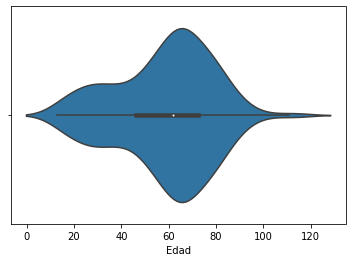

In [28]:
#Distribución de la edad según la frecuencia
sns.violinplot("Edad", hue="Sexo", data=datos, split=True)

Decido dividir las edades en base a posibles patologias y comorbilidades quedando así en 5 intervalos.
Para ello creo una función que recibe como parametros;
- El centro al que calcular la edad
- Limiti inferior/superior
- Simbolo para indicar si es (<,>,entre, etc...)

In [29]:
def edades (cent,limi_inf,simbolo,limi_sup=0):
    centro=datos[datos["Médico"]==cent]
    if simbolo=="<":
        numero=len(centro[centro["Edad"]<limi_inf])
        return numero
    elif simbolo=="entre":
        numero=len(centro[(centro["Edad"]>=limi_inf) & (centro["Edad"]<=limi_sup)])
        return numero
    elif simbolo=="entre_no":
        numero=len(centro[(datos["Edad"]>limi_inf) & (centro["Edad"]<=limi_sup)])
        return numero
    elif simbolo==">":
        numero=len(centro[(centro["Edad"]>limi_inf)])
        return numero

In [30]:
#Calculo los porcentajes de edad para CIDMA
cidma_30=(edades(0,30,"<"))
cidma_30_45=edades(0,30,"entre",45)
cidma_45_65=edades(0,45,"entre_no",65)
cidma_65_80=edades(0,65,"entre_no",80)
cidma_80=(edades(0,80,">"))
#Compruebo que es correcta
cidma_30+cidma_30_45+cidma_45_65+cidma_65_80+cidma_80

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


108

In [31]:
#Calculo los porcentajes de edad para el hospital Italiano
u_30=(edades(1,30,"<"))
u_30_45=edades(1,30,"entre",45)
u_45_65=edades(1,45,"entre_no",65)
u_65_80=edades(1,65,"entre_no",80)
u_80=(edades(1,80,">"))
#Compruebo que es correcta
u_30+u_30_45+u_45_65+u_65_80+u_80

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


143

Así quedaria la represntación de la base de datos

In [32]:
partida=pd.DataFrame({"Pacientes":[[108,str(round((108*100/251),2))+" %"],[143,str(round((143*100/251),2))+" %"],251],
                     "Mujeres":[[65,str(round((65*100/108),2))+" %"],[70,str(round((70*100/143),2))+" %"],[135,str(round((135*100/251),2))+" %"]],
                     "Varones":[[43,str(round((43*100/108),2))+" %"],[73,str(round((73*100/143),2))+" %"],[116,str(round((116*100/251),2))+" %"]],
                     "Edad (<30 años)":[[cidma_30,str(round((cidma_30*100/108),2))+" %"],[u_30,str(round((u_30*100/143),2))+" %"],[32,str(round((32*100/251),2))+" %"]],
                     "Edad [30-45 años]":[[cidma_30_45,str(round((cidma_30_45*100/108),2))+" %"],[u_30_45,str(round((u_30_45*100/143),2))+" %"],[28,str(round((28*100/251),2))+" %"]],
                     "Edad (45-65 años]":[[cidma_45_65,str(round((cidma_45_65*100/108),2))+" %"],[u_45_65,str(round((u_45_65*100/143),2))+" %"],[90,str(round((90*100/251),2))+" %"]],
                     "Edad (65-80 años]":[[cidma_65_80,str(round((cidma_65_80*100/108),2))+" %"],[u_65_80,str(round((u_65_80*100/143),2))+" %"],[71,str(round((71*100/251),2))+" %"]],
                     "Edad (>80 años)":[[cidma_80,str(round((cidma_80*100/108),2))+" %"],[u_80,str(round((u_80*100/143),2))+" %"],[30,str(round((30*100/251),2))+" %"]]}
                     ,index=["CIDMA","Uruguay","Total"])
partida

,Pacientes,Mujeres,Varones,Edad (<30 años),Edad [30-45 años],Edad (45-65 años],Edad (65-80 años],Edad (>80 años)
CIDMA,"[108, 43.03 %]","[65, 60.19 %]","[43, 39.81 %]","[27, 25.0 %]","[19, 17.59 %]","[30, 27.78 %]","[25, 23.15 %]","[7, 6.48 %]"
Uruguay,"[143, 56.97 %]","[70, 48.95 %]","[73, 51.05 %]","[5, 3.5 %]","[9, 6.29 %]","[60, 41.96 %]","[46, 32.17 %]","[23, 16.08 %]"
Total,251,"[135, 53.78 %]","[116, 46.22 %]","[32, 12.75 %]","[28, 11.16 %]","[90, 35.86 %]","[71, 28.29 %]","[30, 11.95 %]"


In [108]:
# Función que crea una nueva variable con los intervalos de edad, para futuras comparaciones
def intervalos (e):
    if e<30:
        return 0
    elif 30<=e<=45:
        return 1
    elif 45<e<=65:
        return 2
    elif 65<e<=80:
        return 3
    else:
        return 4
        

In [109]:
datos["Edad_inter"]=datos["Edad"].apply(intervalos)

In [110]:
datos["Edad_inter"].value_counts()

2    90
3    71
0    32
4    30
1    28
Name: Edad_inter, dtype: int64

In [33]:
#La paso a excel para usar en la presentación
partida.to_excel("datos_base.xlsx")

# Pacientes que no expulsan la cápsula

In [114]:
no_evaluable=['No_evaluable_esof','No_evaluable_estom','No_evaluable_del','No_evaluable_col']

In [115]:
datos['Expulsa_cápsula'].value_counts()

1    179
0     72
Name: Expulsa_cápsula, dtype: int64

In [116]:
#Al ver que hay un valor no recogido y tras analizarlo.Veo que la paciente no llego a expulsar la cápsula y por ello
#lo pongo correctamente
datos[datos['Expulsa_cápsula']==" "]
datos['Expulsa_cápsula'].loc[79]=0

/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [117]:
#La convierto en int la columna
datos['Expulsa_cápsula'] = datos['Expulsa_cápsula'].astype('int64')

In [118]:
cidma_no_ex=datos[(datos['Médico']==0) & (datos['Expulsa_cápsula']==0)]
u_no_ex=datos[(datos['Médico']==1) & (datos['Expulsa_cápsula']==0)]

In [119]:
no_ex_total=len(cidma_no_ex)+len(u_no_ex)

De los 251 pacientes, no llegan a expulsar la cápsula:
    - CIDMA: 39 pacientes
    - Hospital Italiano: 33 pacientes
    - Total: 73 pacientes

Ahora voy a ver en que parte del tracto digestivo la cápsula se quedo retenida, sin bateria etc...  

In [120]:
#Para ello agrupo las variables de los tiempos de tránsito
tiempos=['T_estómago',
 'T_ID_total',
 'T_colon_total',
 'T_expulsión']

In [121]:
#Al ser pocos datos y no haber un criterio unificador de los tiempos, decido analizar las columnas y contarlo
#manualmente
cidma_no_ex[tiempos]
u_no_ex[tiempos]

,T_estómago,T_ID_total,T_colon_total,T_expulsión
1,126,41,500,0
3,660,0,0,0
6,81,8,509,0
9,124,53,559,
11,40,82,,0
13,,,,0
20,33,57,,0
22,36,87,509,0
26,221,108,,0
27,76,,0,0


In [122]:
cidma_colon=34
cidma_no_colon=5
u_colon=24
u_no_colon=9

Creo dos variables para hacer tablas resúmenes

In [123]:
#Función para calcular el porcentaje, recibe dos parámetros:
# a(Es el valor que equilvadría al 100%) + b(La submuestra que queremos concer su %)
def por(a,b):
    x=round((b*100/a),2)
    return x
    

In [124]:
#Función para hacer un cuadro para presentar los datos:
# c_t: CIDMA total // u_t: Uruguay total // primera: nombre 1º columna // c_p: CIDMA primer valor // u_p: Uruguay primer valor
# segunda: (c_s, u_s) // tercera: (c_ter, u_ter)
def cuadro(tema,c_t,u_t,primera,c_p,u_p,segunda,c_s,u_s,tercera=0,c_ter=0,u_ter=0):
    x=pd.DataFrame({tema:[c_t,u_t],
                    primera:[[c_p,por(c_t,c_p)],[u_p,por(u_t,u_p)]], 
                         segunda:[[c_s,por(c_t,c_s)],[u_s,por(u_t,u_s)]],
                       tercera:[[c_ter,por(c_t,c_ter)],[u_ter,por(u_t,u_ter)]],}
                        ,index=["Cidma","Uruguay"])
    return x

In [125]:
#Número de pacientes en los que no se llega a ver el recto
c_no_recto=len(cidma_no_ex[cidma_no_ex["Recto"]==0])

In [126]:
u_no_recto=len(u_no_ex[u_no_ex["Recto"]==0])

In [127]:
cuadro("No expulsadas",len(cidma_no_ex),len(u_no_ex),"Retención en colon",cidma_colon,u_colon,"No llega al colon",cidma_no_colon,u_no_colon,
      "No visión recto",c_no_recto,u_no_recto)

,No expulsadas,Retención en colon,No llega al colon,No visión recto
Cidma,39,"[34, 87.18]","[5, 12.82]","[21, 53.85]"
Uruguay,33,"[24, 72.73]","[9, 27.27]","[30, 90.91]"


In [128]:
print("Edad media de los pacientes que no expulsaron la cápsula en CIDMA {}".format(cidma_no_ex["Edad"].mean()))
print("Edad media de los pacientes que no expulsaron la cápsula en Uruguay {}".format(u_no_ex["Edad"].mean()))

Edad media de los pacientes que no expulsaron la cápsula en CIDMA 50.69230769230769
Edad media de los pacientes que no expulsaron la cápsula en Uruguay 66.60606060606061


In [130]:
#Miro los distintos intervalos de edades
cidma_no_ex["Edad_inter"].value_counts()

3    11
0    11
2     9
1     5
4     3
Name: Edad_inter, dtype: int64

In [219]:
cidma_no_ex[cidma_no_ex["Edad_inter"]==0].mean()

Médico                     0.000000
Tipo_cápsula               0.909091
ID                       162.727273
Sexo                       0.363636
Edad                      22.272727
                          ...      
Intro_cápsula              0.000000
Complicaciones        909090.909091
Hernia_hiato_total         0.181818
Enf_II                     0.000000
Edad_inter                 0.000000
Length: 143, dtype: float64

In [131]:
u_no_ex["Edad_inter"].value_counts()

2    16
3    12
4     4
1     1
Name: Edad_inter, dtype: int64

In [175]:
#Pacientes menores de 30 años de cidma con calidad de preparación inferior a excelente
len(cidma_no_ex[((cidma_no_ex['Calidad_preparación']==0) | (cidma_no_ex['Calidad_preparación']==1) 
                 |(cidma_no_ex['Calidad_preparación']==2))
                   & (cidma_no_ex['Edad_inter']==0) ])

7

In [212]:
#Agrupo las columnas medicamento en una única variable para su mejor análisis
medicacion=['Antidiabético',
 'AINE',
 'Antiagregante',
 'Anticoagulante',
 'Benzodiacepina',
 'ARAII',
 'IBP',
 'Inmunosupresores',
 'Diurético',
 'Antiemético',
 'Vitaminas',
 'Antimicrobiano',
 'Otros_med']

In [211]:
#Analizo la medicación que toman los pacientes del intervalo de edad 0
cidma_no_ex[cidma_no_ex['Edad_inter']==0][medicacion]

,Antidiabético,AINE,Antiagregante,Anticoagulante,Benzodiacepina,ARAII,IBP,Inmunosupresores,Diurético,Antiemético,Vitaminas,Antimicrobiano,Otros_med
63,0,0,0,1,0,0,1,0,0,0,0,0,1
106,0,0,0,0,0,0,0,0,0,0,0,0,0
154,0,1,0,0,0,0,0,0,0,0,0,0,0
160,0,0,0,0,0,0,0,0,0,0,0,0,0
161,0,0,0,0,0,0,1,0,0,1,0,0,0
163,0,0,0,0,0,0,0,0,0,0,0,0,1
165,0,0,0,0,0,0,0,0,0,0,0,0,0
194,0,0,0,0,0,0,0,0,0,0,0,0,0
197,0,0,0,0,0,0,0,0,0,0,0,0,0
207,0,0,0,0,0,0,0,0,0,0,0,0,0


# <font color='blue'>Expulsión cápsula</font>

Como se observa 73 cápsulas no han sido expulsadas, suponiendo el 29% del total de los pacientes. Destacando la elevada retención de ellas en el colon el 79,4%, las cuales llegan a distintas alturas del colon. 
Llama la antención que el 69,8% no llega a visionar el recto. 
En cuanto a la edad media de los pacientes, que no llegaron a expulsar es de 50 y 65 años, en CIDMA y el hospital italiano respectivamente. Lo que nos indica que puede exitir un sesgo importante, al equivaler la población en dicho rango de edad al 63% del tamaño muestral. Por ello decido analizar los diferentes rangos de edad. 

Observandose que efectivamente el hospital italiano tiene tan solo 5 cápsulas fuera del intervalo 45-80 años. Sin embargo la distribución de la edad en CIDMA es mas rica, teniendo dos picos de 11 pacientes cada uno, el primero por debajo de 30 años y el otro entre 65-80 años. 

Lo que llama la atención es que prácticamente la mitad de los pacientes de menos de 30 años de cidma, no hayan llegado a expulsar las cápsulas. a diferencia con los pacientes menores de 30 del hospital italiano, donde todos llegaron expulsarla. 

Buscando posibles causas, evaluo las indicaciones de estos pacientes (No expulsa + <30 años) 8 de ellos vienen por dolor abdominal. Ninguno tuvo cirugía previa y solo 2 tomaban algún tipo de medicación previa destacable. Por lo que el motivo principal puede ser la calidad de la preparación, donde se ve que 7 tienen un calidad entre pobre y buena, de los cuales 2 no llegaron a hacer una limpieza de colon adecuada.

Esto podría explicarse por la corta edad de los pacientes, con una edad media de 22 años.

# Pacientes con cápsulas no patológicas, cuyo tracto gastrointestinal fue evaluado al completo y se aprecio las estructuras principales

In [220]:
#Agrupo las columnas con las variables que representan las estructuras principales
basicos=['Linea_Z',
 'Ampolla_vater',
 'Válvula_ileocecal',
 'Orificio_apendicular',
 'Flexura_hepática',
 'Flexura_esplénica',
 'Recto']

# Porcentaje de pacientes que vinieron con síntomas de dolor abdominal y tuvieron hallazgos en la cápsula. Diferenciando entre el centro en el que fue realizada la prueba.

Para ello, agrupo primero todas las varibles que representan hallazgos en la cápsula endoscopica. Los agrupo en dos 
tipos:
- Hallazgos que permiten tratamiento sin la necesidad de pruebas complementarias
- Hallazgos que harían necesaria la realización de pruebas complementaris para el diagnostico completo.

También defino otros conceptos:
- Normal: Paciente sin hallazgos patológicos
- No evaluable: Por diversos motivos, no se pudo estudiar algun trazo del tracto gastrointestinal completamente.

In [48]:
hz_Tta=["Hernia_hiato_total",
 'RGE_esof',
 'Erosiones_esof',
 'Erosiones_estom',
 'Pólipo_estom',
 'Telangiectasias_yey',
 'Linfagiectasias_yey',
 'Pólipo_yey',
 'Diverticulo_íleon',
'Erosiones_del',
 'Diverticulo_del',
 'Enteritis_del',
 'Pólipo_del',
 'Otros_del',
 'Hemorroides',
 'Diverticulo_col',
 'Diverticulo_C_drch',
 'Diverticulo_sig',
 'Diverticulo_C_izq',
 'Sigmoiditis',
 'Proctitis',
 'Angiodisplasia_col',
 'Pólipo_col',
 'Pólipo_C_drch',
 'Pólipo_C_asce',
 'Pólipo_C_trans',
 'Pólipo_C_izq',
 'Pólipo_C_desc',
 'Pólipo_ciego',
 'Pólipo_sig',
 'Pólipo_recto',
 'Melanosis',
 'Otras_col']

In [49]:
hz_prueba=['Trast_tránsito_esof',  'Barret_esof',  'Esof_eosinofilica_esof',  'Estenosis_extr_esof',  
           'Trast_motilidad_estom','Gastritis_estom',  'Yeyunitis',  'Erosiones_yey',  'Ileitis', 
           'Erosiones_íleon',  'Pólipo_íleon',  'Erosiones_col', 'Otros_estom',]

En cuanto a las variables otros hallazgos de estómago, delgado y colon decido incluirlas en hz_Tta porque en su
mayoria son de este tipo, aunque según resultados posteriores decidire si sacarlas, en base a posibles alteraciones 
en el analisis final.

In [50]:
cidma_dolor = datos[(datos['Médico']==0) & 
                (datos['Dolor_abd']==1)]

In [51]:
#Número de pacientes con dolor abdominal del centro CIDMA
cidma_dolor.shape 

(53, 149)

In [52]:
cidma_dolor["Hz_Tta"] = cidma_dolor[hz_Tta].sum(axis=1)

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
#Número de pacientes con hallazgos para futuras terapías
len(cidma_dolor[cidma_dolor["Hz_Tta"]>=1])

39

In [54]:
cidma_dolor["Hz_Prueba"] = cidma_dolor[hz_prueba].sum(axis=1) 

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
#Número de pacientes con hallazgos para futuros estudios
len(cidma_dolor[cidma_dolor["Hz_Prueba"]>=1]) 

33

In [56]:
#Número de pacientes con hallazgos compatibles con la normalidad
pct_normal=cidma_dolor[(cidma_dolor["Hz_Tta"]==0)&
(cidma_dolor["Hz_Prueba"]==0)]                     
len(pct_normal)

6

In [57]:
no_evaluable=['No_evaluable_esof','No_evaluable_estom','No_evaluable_del','No_evaluable_col']

In [58]:
#Número de pacientes con zonas del tracto GI sin posible evaluación
no_visi=[]
No_visi=[]
for e in no_evaluable:
    a=cidma_dolor[e].isin([1])
    for i in a:
        if i==1:
            b=cidma_dolor[e][a].index
            no_visi.append(b)
        elif len(no_visi)>=1:
            for j in no_visi:
                for x in j:
                    No_visi.append(x)
        elif len(no_visi)==0:
            No_visi=[]

NO_VISIBLE=set(No_visi)
len(NO_VISIBLE)

15

In [59]:
#Pacientes sin hallazgos patologicos con zonas del tracto gigestivo no evaluables
for e in NO_VISIBLE:
    for i in pct_normal.index:
        if e==i:
            print(e)

153
154


In [60]:
cidma_dolor[no_evaluable].loc[153:154]

,No_evaluable_esof,No_evaluable_estom,No_evaluable_del,No_evaluable_col
153,0,0,1,0
154,0,0,0,1


In [61]:
#Todos los pacientes con zonas no evaluables
cidma_dolor[(cidma_dolor['No_evaluable_esof']==1) | (cidma_dolor["No_evaluable_estom"]==1)
       | (cidma_dolor['No_evaluable_del']==1) | (cidma_dolor['No_evaluable_col']==1)][no_evaluable]

,No_evaluable_esof,No_evaluable_estom,No_evaluable_del,No_evaluable_col
105,0,0,0,1
114,0,0,0,1
130,0,0,0,1
153,0,0,1,0
154,0,0,0,1
156,0,0,0,1
160,0,0,0,1
165,0,0,0,1
166,0,1,0,0
180,0,0,1,1


Como se ve solo dos pacientes no presentarian hallazgos patológicos y tendrían alguna zona del tracto digestivo sin poder evaluar (delgado, colon). En cuanto al resto de pacientes con zonas no evaluables, destacar la zona colónica como la principal área no evaluada con hasta 11 pacientes.

Ahora veré cuales son los pricipales hallazgos de dichos pacientes.
En primer lugar los hallazgos para tratamiento

In [62]:
dic={}
for e in hz_Tta:
    b=cidma_dolor[e].value_counts()
    dic[e]=b
    

In [63]:
hz_Tta_frec={}
for e in hz_Tta:
    if len(dic[e])>1:
        hz_Tta_frec[e]=dic[e][1]

In [64]:
sorted(hz_Tta_frec.items(), key=operator.itemgetter(1),reverse=True)

[('Diverticulo_col', 16),
 ('Hernia_hiato_total', 14),
 ('Hemorroides', 14),
 ('RGE_esof', 9),
 ('Otras_col', 8),
 ('Diverticulo_C_izq', 7),
 ('Diverticulo_sig', 6),
 ('Erosiones_estom', 5),
 ('Pólipo_estom', 5),
 ('Pólipo_col', 5),
 ('Otros_del', 4),
 ('Diverticulo_C_drch', 4),
 ('Linfagiectasias_yey', 3),
 ('Erosiones_del', 3),
 ('Enteritis_del', 3),
 ('Melanosis', 3),
 ('Angiodisplasia_col', 2),
 ('Erosiones_esof', 1),
 ('Diverticulo_íleon', 1),
 ('Pólipo_C_drch', 1),
 ('Pólipo_C_izq', 1),
 ('Pólipo_ciego', 1),
 ('Pólipo_sig', 1),
 ('Pólipo_recto', 1)]

Como se observa los tres hallazgos principales son:
- Diverticulos en colon
- Hernia de hiato
- Hemorroides

En cuanto a los hallazgos para completar estudio

In [65]:
dic={}
for e in hz_prueba:
    b=cidma_dolor[e].value_counts()
    dic[e]=b
    
hz_prueba_frec={}
for e in hz_prueba:
    if len(dic[e])>1:
        hz_prueba_frec[e]=dic[e][1]

In [66]:
sorted(hz_prueba_frec.items(), key=operator.itemgetter(1),reverse=True)

[('Gastritis_estom', 15),
 ('Yeyunitis', 5),
 ('Trast_tránsito_esof', 3),
 ('Erosiones_col', 3),
 ('Otros_estom', 3),
 ('Trast_motilidad_estom', 2),
 ('Erosiones_yey', 2),
 ('Ileitis', 2),
 ('Erosiones_íleon', 2),
 ('Barret_esof', 1),
 ('Esof_eosinofilica_esof', 1),
 ('Pólipo_íleon', 1)]

Principales hallazgos que necesitaran nuevas pruebas, destacan:
- Gastritis (Este triplica la frecuencia del segundo)
- Yeyunitis
- Trastornos del tránsito esofágico

Ahora analizaré las mismas variables en el hospital Italiano

In [67]:
uruguay_dolor = datos[(datos['Médico']==1) & 
                (datos['Dolor_abd']==1)]

In [68]:
#Número de pacientes con dolor abdominal en el hospital Italiano
len(uruguay_dolor["Médico"])

8

In [69]:
uruguay_dolor[hz_Tta].iloc[:,:20]

,Hernia_hiato_total,RGE_esof,Erosiones_esof,Erosiones_estom,Pólipo_estom,Telangiectasias_yey,Linfagiectasias_yey,Pólipo_yey,Diverticulo_íleon,Erosiones_del,Diverticulo_del,Enteritis_del,Pólipo_del,Otros_del,Hemorroides,Diverticulo_col,Diverticulo_C_drch,Diverticulo_sig,Diverticulo_C_izq,Sigmoiditis
45,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
173,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [70]:
uruguay_dolor["Hz_Tta"] = uruguay_dolor[hz_Tta].sum(axis=1)

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [71]:
#Número de pacientes con hallazgos para futuras terapías
len(uruguay_dolor[uruguay_dolor["Hz_Tta"]>=1])

5

In [72]:
uruguay_dolor["Hz_Prueba"] = uruguay_dolor[hz_prueba].sum(axis=1)

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
#Número de pacientes con hallazgos para estudios complementarios
len(uruguay_dolor[uruguay_dolor["Hz_Prueba"]>=1])

3

In [74]:
#Número de pacientes con hallazgos compatibles con la normalidad
pct_normal_uru=uruguay_dolor[(uruguay_dolor["Hz_Tta"]==0)&
(uruguay_dolor["Hz_Prueba"]==0)]                    
len(pct_normal_uru)

3

In [75]:
#Número de pacientes con zonas del tracto GI sin posible evaluación (1)
uruguay_dolor[no_evaluable] 

,No_evaluable_esof,No_evaluable_estom,No_evaluable_del,No_evaluable_col
45,0,0,0,0
65,1,1,0,0
66,0,0,0,0
99,0,0,0,0
152,0,0,0,0
164,0,0,0,0
173,0,0,0,0
250,0,0,0,0


In [76]:
pct_normal_uru.index 

Int64Index([65, 164, 173], dtype='int64')

Como se ve uno de los pacientes (65) que no tiene hallazgos, tiene el esófago y el estómago sin evaluar.

In [77]:
uruguay_dolor[hz_Tta].sum(axis=0)

Hernia_hiato_total     0.0
RGE_esof               0.0
Erosiones_esof         0.0
Erosiones_estom        0.0
Pólipo_estom           0.0
Telangiectasias_yey    0.0
Linfagiectasias_yey    0.0
Pólipo_yey             0.0
Diverticulo_íleon      0.0
Erosiones_del          0.0
Diverticulo_del        0.0
Enteritis_del          0.0
Pólipo_del             0.0
Otros_del              0.0
Hemorroides            0.0
Diverticulo_col        1.0
Diverticulo_C_drch     0.0
Diverticulo_sig        1.0
Diverticulo_C_izq      0.0
Sigmoiditis            2.0
Proctitis              0.0
Angiodisplasia_col     0.0
Pólipo_col             4.0
Pólipo_C_drch          1.0
Pólipo_C_asce          1.0
Pólipo_C_trans         0.0
Pólipo_C_izq           0.0
Pólipo_C_desc          0.0
Pólipo_ciego           0.0
Pólipo_sig             1.0
Pólipo_recto           1.0
Melanosis              0.0
Otras_col              1.0
dtype: float64

In [78]:
#Hallazgos para posterior estuido complementario 
uruguay_dolor[uruguay_dolor["Hz_Prueba"]>=1][hz_prueba]

,Trast_tránsito_esof,Barret_esof,Esof_eosinofilica_esof,Estenosis_extr_esof,Trast_motilidad_estom,Gastritis_estom,Yeyunitis,Erosiones_yey,Ileitis,Erosiones_íleon,Pólipo_íleon,Erosiones_col,Otros_estom
45,0,0,0,0,0,0,0,1,0,0,0,0,0
66,0,0,0,0,0,0,0,0,0,0,0,1,0
99,0,0,0,0,0,0,0,0,1,0,0,0,0


Hallazgos más frecuentes:
- Hz Tratamiento: Pólipos en colon (4), sigmoiditis, resto todos con 1.
- Hz Pruebas: Erosiones (Yeyuno, colon), ileitis.

In [79]:
pregunta_1=pd.DataFrame({"Pacientes":[53,8],"Normal":[[6,str(round((6*100/53),2))+" %"],[3,str(round((3*100/8),2))+" %"]], 
                         "No evaluable":[[15,str(round((15*100/53),2))+" %"],[1,str(round((1*100/8),2))+" %"]],
                       "Hz Pruebas":[[33,str(round((33*100/53),2))+" %"],[3,str(round((3*100/8),2))+" %"]],
                         "Hz Tratamiento":[[39,str(round((39*100/53),2))+" %"],[5,str(round((5*100/8),2))+" %"]]}
                        ,index=["Cidma","Uruguay"])
display(pregunta_1)


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,53,"[6, 11.32 %]","[15, 28.3 %]","[33, 62.26 %]","[39, 73.58 %]"
Uruguay,8,"[3, 37.5 %]","[1, 12.5 %]","[3, 37.5 %]","[5, 62.5 %]"


# <font color='blue'>Número de pacientes y porcentajes</font>

Se observa que un 88,68% de los pacientes de CIDMA a los que se le hizo la cápsula por síntomas de dolor abdominal presentaron hallazgos de algún tipo. Destacando el 73,58% que recibieron un diagnostico definitivo, sin necesidad de pruebas complementarias. Sin embargo ese porcentaje cae al 62,5% en los pacientes del hospital Italiano, pero que aún así permite observar una capacidad de deteción de hallazgos de mas del 60%.

# Resto de indicaciones
Para el resto de indicaciones decido crear una función que recibiendo como entrada la indicación a analizar, devuelva
el cuadro con los porcentajes y hallazgos mas frecuentes





In [80]:
# Todas las posibles indicaciones del estudio
indicacion=['HDOO_oculta',
 'HDOO_mani',
 'Crohn',
 'Alt_tránsito',
 'Anemia',
 'Dolor_abd',
 'Estreñimiento',
 'Diarrea',
 'Vómitos',
 'Pérdida_peso',
 'EII',
"Enf_II",
 'Colono_imcp',
 'Cribado',
 'Revisión',
 'Otros_indica']

Organizo las indicaciones en base a la literatura

In [81]:

indicaciones_clasicas=['HDOO_oculta','HDOO_mani',"Cribado",'Anemia','Colono_imcp',"Enf_II",'Revisión']
indicaciones_nuevas=['Alt_tránsito','Dolor_abd','Estreñimiento','Diarrea','Vómitos','Pérdida_peso','Otros_indica']

In [82]:
#Evaluó las otras indicaciones para analizar cuales son las más frecuentes
datos[indicacion].sum(axis=0)

HDOO_oculta      23
HDOO_mani        15
Crohn             4
Alt_tránsito      3
Anemia           25
Dolor_abd        61
Estreñimiento     6
Diarrea          35
Vómitos          10
Pérdida_peso      8
EII               5
Enf_II            9
Colono_imcp      10
Cribado          58
Revisión         18
Otros_indica     19
dtype: int64

In [83]:
#Función que recibe una indicación y mira el número de pacientes (CIDMA, Uruguay) y calcular (número y porcentaje) 
#de hallazgos terapéutico, pruebas complementarias y no evaluables. 
#Junto a eso también porporciona los hallazgos más frecuentes y si de los pacientes sin hallazgos clasificados como
#Normal tienen zonas no evaluadas.


#NOTA: Para entender la función, se desgrana mejor apartir del else, el resto es lo mismo pero mas agrupado y 
#recortado
def porcentajes (indicacion):
    cidma_a = datos[(datos['Médico']==0) & (datos[indicacion]==1)]
    uruguay_b= datos[(datos['Médico']==1) & (datos[indicacion]==1)]
    paciente_indicacion=len(cidma_a)
    paciente_indicacion_uru=len(uruguay_b)
    
    if paciente_indicacion==0:
        uruguay_b["Hz_Tta"] = uruguay_b[hz_Tta].sum(axis=1)
        hzgs_T_uruguay=len(uruguay_b[uruguay_b["Hz_Tta"]>=1])
        uruguay_b["Hz_Prueba"] = uruguay_b[hz_prueba].sum(axis=1) 
        hzgs_P_uruguay=len(uruguay_b[uruguay_b["Hz_Prueba"]>=1])
        norml_uruguay=uruguay_b[(uruguay_b["Hz_Tta"]==0)&
                               (uruguay_b["Hz_Prueba"]==0)]                     
        normal_uruguay=len(norml_uruguay)
        no_visi_uruguay=[]
        No_visi_uruguay=[]
        for e in no_evaluable:
            a_uru=uruguay_b[e].isin([1])
            for i in a_uru:
                if i==1:
                    b_uru=uruguay_b[e][a_uru].index
                    no_visi_uruguay.append(b_uru)
                elif len(no_visi_uruguay)>=1:
                    for j in no_visi_uruguay:
                        for x in j:
                            No_visi_uruguay.append(x)
                elif len(no_visi_uruguay)==0:
                    No_visi_uruguay=[]
        NO_VISIBLE_uruguay=set(No_visi_uruguay)
        no_eva_uruguay=len(NO_VISIBLE_uruguay)  
        N_No_eva_urugua=[]
        for e in NO_VISIBLE_uruguay:
            for i in norml_uruguay.index:
                if e==i:
                    N_No_eva_urugua.append(e)
        N_No_eva_uruguay=len(N_No_eva_urugua)                                          
        dic_b={}
        for e in hz_Tta:
            b=uruguay_b[e].value_counts()
            dic_b[e]=b
        hz_Tta_frec_uruguay={}
        for e in hz_Tta:
            if len(dic_b[e])>1:
                hz_Tta_frec_uruguay[e]=dic_b[e][1]
            elif len(dic_b[e])==1:
                if dic_b[e].keys()==0:
                    del dic_b[e]
            else:
                hz_Tta_frec_uruguay[e]=dic_b[e][1]
        hz_Tta_frec_uruguay=sorted(hz_Tta_frec_uruguay.items(), key=operator.itemgetter(1),reverse=True)
        for e in hz_prueba:
            c=uruguay_b[e].value_counts()
            dic_b[e]=c      
        hz_prueba_frec_uruguay={}
        for e in hz_prueba:
            if len(dic_b[e])>1:
                hz_prueba_frec_uruguay[e]=dic_b[e][1]
            elif len(dic_b[e])==1:
                if dic_b[e].keys()==0:
                    del dic_b[e]
            else:
                hz_prueba_frec_uruguay[e]=dic_b[e][1]
        hz_prueba_frec_uruguay=sorted(hz_prueba_frec_uruguay.items(), key=operator.itemgetter(1),reverse=True)
        
        pregunta=pd.DataFrame({"Pacientes":["NO",paciente_indicacion_uru],
                                 "Normal":[["NO"],[normal_uruguay,str(round((normal_uruguay*100/paciente_indicacion_uru),2))+" %"]], 
                             "No evaluable":[["NO"],[no_eva_uruguay,str(round((no_eva_uruguay*100/paciente_indicacion_uru),2))+" %"]],
                           "Hz Pruebas":[["NO"],[hzgs_P_uruguay,str(round((hzgs_P_uruguay*100/paciente_indicacion_uru),2))+" %"]],
                             "Hz Tratamiento":[["NO"],[hzgs_T_uruguay,str(round((hzgs_T_uruguay*100/paciente_indicacion_uru),2))+" %"]]}
                            ,index=["Cidma","Uruguay"])

        return (pregunta,"{} Uruguay hallazgos terapeúticos más frecuentes {}".format(indicacion,hz_Tta_frec_uruguay[0:3]),
               "{} Uruguay hallazgos pruebas complementarias {}".format(indicacion,hz_prueba_frec_uruguay[0:3]),
                "Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables {}".format(N_No_eva_uruguay),
               "No CIDMA","No CIDMA","No CIDMA")
    
                
    elif paciente_indicacion_uru==0:
        cidma_a["Hz_Tta"] = cidma_a[hz_Tta].sum(axis=1)
        hzgs_T_cidma=len(cidma_a[cidma_a["Hz_Tta"]>=1])
        cidma_a["Hz_Prueba"] = cidma_a[hz_prueba].sum(axis=1) 
        hzgs_P_cidma=len(cidma_a[cidma_a["Hz_Prueba"]>=1])
        norml_cidma=cidma_a[(cidma_a["Hz_Tta"]==0)&(cidma_a["Hz_Prueba"]==0)]                     
        normal_cidma=len(norml_cidma)
        no_visi_cidma=[]
        No_visi_cidma=[]
        for e in no_evaluable:
            a=cidma_a[e].isin([1])
            for i in a:
                if i==1:
                    b=cidma_a[e][a].index
                    no_visi_cidma.append(b)
                elif len(no_visi_cidma)>=1:
                    for j in no_visi_cidma:
                        for x in j:
                            No_visi_cidma.append(x)
                elif len(no_visi_cidma)==0:
                    No_visi_cidma=[]
        NO_VISIBLE_cidma=set(No_visi_cidma)
        no_eva_cidma=len(NO_VISIBLE_cidma)              
        N_No_eva_cidm=[]
        for e in NO_VISIBLE_cidma:
            for i in norml_cidma.index:
                if e==i:
                    N_No_eva_cidm.append(e)
        N_No_eva_cidma=len(N_No_eva_cidm)                                 
        dic={}
        for e in hz_Tta:
            b=cidma_a[e].value_counts()
            dic[e]=b
        hz_Tta_frec_cidma={}
        for e in hz_Tta:
            if len(dic[e])>1:
                hz_Tta_frec_cidma[e]=dic[e][1]
            elif len(dic[e])==1:
                if dic[e].keys()==0:
                    del dic[e]
            else:
                hz_Tta_frec_cidma[e]=dic[e][1]
        hz_Tta_frec_cidma=sorted(hz_Tta_frec_cidma.items(), key=operator.itemgetter(1),reverse=True)
        dic={}
        for e in hz_prueba:
            b=cidma_a[e].value_counts()
            dic[e]=b
        dic_b={}
        hz_prueba_frec_cidma={}
        for e in hz_prueba:
            if len(dic[e])>1:
                hz_prueba_frec_cidma[e]=dic[e][1]
            elif len(dic[e])==1:
                if dic[e].keys()==0:
                    del dic[e]
            else:
                hz_prueba_frec_cidma[e]=dic[e][1]
        hz_prueba_frec_cidma=sorted(hz_prueba_frec_cidma.items(), key=operator.itemgetter(1),reverse=True)
        
        pregunta=pd.DataFrame({"Pacientes":[paciente_indicacion,"NO"],
                                 "Normal":[[normal_cidma,str(round((normal_cidma*100/paciente_indicacion),2))+" %"],["NO"]], 
                             "No evaluable":[[no_eva_cidma,str(round((no_eva_cidma*100/paciente_indicacion),2))+" %"],["NO"]],
                           "Hz Pruebas":[[hzgs_P_cidma,str(round((hzgs_P_cidma*100/paciente_indicacion),2))+" %"],["NO"]],
                             "Hz Tratamiento":[[hzgs_T_cidma,str(round((hzgs_T_cidma*100/paciente_indicacion),2))+" %"],["NO"]]},index=["Cidma","Uruguay"])
        
        return (pregunta,"{} CIDMA hallazgos terapeúticos más frecuentes {}".format(indicacion,hz_Tta_frec_cidma[0:3]),
               "{} CIDMA hallazgos pruebas complementarias {}".format(indicacion,hz_prueba_frec_cidma[0:3]),
                "CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables {}".format(N_No_eva_cidma),
               "NO Uruguay","No Uruguay","No Uruguay")
    else:
        #Número de pacientes con hallazgos para futuras terapías
        #CIDMA
        cidma_a["Hz_Tta"] = cidma_a[hz_Tta].sum(axis=1)
        hzgs_T_cidma=len(cidma_a[cidma_a["Hz_Tta"]>=1])
        #Uruguay
        uruguay_b["Hz_Tta"] = uruguay_b[hz_Tta].sum(axis=1)
        hzgs_T_uruguay=len(uruguay_b[uruguay_b["Hz_Tta"]>=1])

        #Número de pacientes con hallazgos para futuros estudios
        #CIDMA
        cidma_a["Hz_Prueba"] = cidma_a[hz_prueba].sum(axis=1) 
        hzgs_P_cidma=len(cidma_a[cidma_a["Hz_Prueba"]>=1]) 
        #Uruguay
        uruguay_b["Hz_Prueba"] = uruguay_b[hz_prueba].sum(axis=1) 
        hzgs_P_uruguay=len(uruguay_b[uruguay_b["Hz_Prueba"]>=1])

        #Número de pacientes con hallazgos compatibles con la normalidad
        #CIDMA
        norml_cidma=cidma_a[(cidma_a["Hz_Tta"]==0)&
                               (cidma_a["Hz_Prueba"]==0)]                     
        normal_cidma=len(norml_cidma)
        #Uruguay
        norml_uruguay=uruguay_b[(uruguay_b["Hz_Tta"]==0)&
                               (uruguay_b["Hz_Prueba"]==0)]                     
        normal_uruguay=len(norml_uruguay)

        #Número de pacientes con zonas del tracto GI sin posible evaluación
        #CIDMA
        no_visi_cidma=[]
        No_visi_cidma=[]
        for e in no_evaluable:
            a=cidma_a[e].isin([1])
            for i in a:
                if i==1:
                    b=cidma_a[e][a].index
                    no_visi_cidma.append(b)
                elif len(no_visi_cidma)>=1:
                    for j in no_visi_cidma:
                        for x in j:
                            No_visi_cidma.append(x)
                elif len(no_visi_cidma)==0:
                    No_visi_cidma=[]
        NO_VISIBLE_cidma=set(No_visi_cidma)
        no_eva_cidma=len(NO_VISIBLE_cidma)  
        
        #Pacientes sin hallazgos patologicos con zonas del tracto digestivo no evaluables
        N_No_eva_cidm=[]
        for e in NO_VISIBLE_cidma:
            for i in norml_cidma.index:
                if e==i:
                    N_No_eva_cidm.append(e)
        N_No_eva_cidma=len(N_No_eva_cidm)
        #Uruguay
        no_visi_uruguay=[]
        No_visi_uruguay=[]
        for e in no_evaluable:
            a_uru=uruguay_b[e].isin([1])
            for i in a_uru:
                if i==1:
                    b_uru=uruguay_b[e][a_uru].index
                    no_visi_uruguay.append(b_uru)
                elif len(no_visi_uruguay)>=1:
                    for j in no_visi_uruguay:
                        for x in j:
                            No_visi_uruguay.append(x)
                elif len(no_visi_uruguay)==0:
                    No_visi_uruguay=[]
        NO_VISIBLE_uruguay=set(No_visi_uruguay)
        no_eva_uruguay=len(NO_VISIBLE_uruguay)  
        

        N_No_eva_urugua=[]
        for e in NO_VISIBLE_uruguay:
            for i in norml_uruguay.index:
                if e==i:
                    N_No_eva_urugua.append(e)
        N_No_eva_uruguay=len(N_No_eva_urugua)   
        
        
        #Hallazgos tratamientos más frecuentes
        #CIDMA
        dic={}
        for e in hz_Tta:
            b=cidma_a[e].value_counts()
            dic[e]=b
        
    
        hz_Tta_frec_cidma={}
        for e in hz_Tta:
            if len(dic[e])>1:
                hz_Tta_frec_cidma[e]=dic[e][1]
            elif len(dic[e])==1:
                if dic[e].keys()==0:
                    del dic[e]
            else:
                hz_Tta_frec_cidma[e]=dic[e][1]
        hz_Tta_frec_cidma=sorted(hz_Tta_frec_cidma.items(), key=operator.itemgetter(1),reverse=True)
        
        #Uruguay
        dic_b={}
        for e in hz_Tta:
            b=uruguay_b[e].value_counts()
            dic_b[e]=b
        
        hz_Tta_frec_uruguay={}
        for e in hz_Tta:
            if len(dic_b[e])>1:
                hz_Tta_frec_uruguay[e]=dic_b[e][1]
            elif len(dic_b[e])==1:
                if dic_b[e].keys()==0:
                    del dic_b[e]
            else:
                hz_Tta_frec_uruguay[e]=dic[e][1]
        hz_Tta_frec_uruguay=sorted(hz_Tta_frec_uruguay.items(), key=operator.itemgetter(1),reverse=True)

        #Hallazgos pruebas complementarias mas frecuentes
        #CIDMA
        dic={}
        for e in hz_prueba:
            b=cidma_a[e].value_counts()
            dic[e]=b
        hz_prueba_frec_cidma={}
        for e in hz_prueba:
            if len(dic[e])>1:
                hz_prueba_frec_cidma[e]=dic[e][1]
            elif len(dic[e])==1:
                if dic[e].keys()==0:
                    del dic[e]
            else:
                hz_prueba_frec_cidma[e]=dic[e][1]
        hz_prueba_frec_cidma=sorted(hz_prueba_frec_cidma.items(), key=operator.itemgetter(1),reverse=True)
        
        #Uruguay
        dic_b={}
        for e in hz_prueba:
            c=uruguay_b[e].value_counts()
            dic_b[e]=c 
        hz_prueba_frec_uruguay={}
        for e in hz_prueba:
            if len(dic_b[e])>1:
                hz_prueba_frec_uruguay[e]=dic_b[e][1]
            elif len(dic_b[e])==1:
                if dic_b[e].keys()==0:
                    del dic_b[e]
            else:
                hz_prueba_frec_uruguay[e]=dic_b[e][1]
        hz_prueba_frec_uruguay=sorted(hz_prueba_frec_uruguay.items(), key=operator.itemgetter(1),reverse=True)


        pregunta=pd.DataFrame({"Pacientes":[paciente_indicacion,paciente_indicacion_uru],
                                 "Normal":[[normal_cidma,str(round((normal_cidma*100/paciente_indicacion),2))+" %"],[normal_uruguay,str(round((normal_uruguay*100/paciente_indicacion_uru),2))+" %"]], 
                             "No evaluable":[[no_eva_cidma,str(round((no_eva_cidma*100/paciente_indicacion),2))+" %"],[no_eva_uruguay,str(round((no_eva_uruguay*100/paciente_indicacion_uru),2))+" %"]],
                           "Hz Pruebas":[[hzgs_P_cidma,str(round((hzgs_P_cidma*100/paciente_indicacion),2))+" %"],[hzgs_P_uruguay,str(round((hzgs_P_uruguay*100/paciente_indicacion_uru),2))+" %"]],
                             "Hz Tratamiento":[[hzgs_T_cidma,str(round((hzgs_T_cidma*100/paciente_indicacion),2))+" %"],[hzgs_T_uruguay,str(round((hzgs_T_uruguay*100/paciente_indicacion_uru),2))+" %"]]}
                            ,index=["Cidma","Uruguay"])


        return (pregunta,"{} CIDMA hallazgos terapeúticos más frecuentes {}".format(indicacion,hz_Tta_frec_cidma[0:3]),
               "{} CIDMA hallazgos pruebas complementarias {}".format(indicacion,hz_prueba_frec_cidma[0:3]), 
                "CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables {}".format(N_No_eva_cidma),
                "{} Uruguay hallazgos terapeúticos más frecuentes {}".format(indicacion,hz_Tta_frec_uruguay[0:3]),
                "{} Uruguay hallazgos pruebas complementarias más frecuentes {}".format(indicacion,hz_prueba_frec_uruguay[0:3]),
                "Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables {}".format(N_No_eva_uruguay))
    

In [84]:
#Aplico la función en todas las indicaciones
for e in indicacion:
    a,b,c,d,e,f,g=porcentajes(e)
    display(a)
    print(b)
    print(c)
    print(d)
    print(e)
    print(f)
    print(g)
    

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,9,"[0, 0.0 %]","[2, 22.22 %]","[3, 33.33 %]","[9, 100.0 %]"
Uruguay,14,"[1, 7.14 %]","[3, 21.43 %]","[5, 35.71 %]","[11, 78.57 %]"


HDOO_oculta CIDMA hallazgos terapeúticos más frecuentes [('Hemorroides', 6), ('Diverticulo_col', 6), ('Pólipo_col', 6)]
HDOO_oculta CIDMA hallazgos pruebas complementarias [('Estenosis_extr_esof', 2), ('Gastritis_estom', 1), ('Erosiones_íleon', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
HDOO_oculta Uruguay hallazgos terapeúticos más frecuentes [('Pólipo_col', 7), ('Diverticulo_col', 4), ('Pólipo_sig', 3)]
HDOO_oculta Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_íleon', 2), ('Gastritis_estom', 1), ('Erosiones_yey', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,3,"[0, 0.0 %]","[0, 0.0 %]","[2, 66.67 %]","[3, 100.0 %]"
Uruguay,12,"[3, 25.0 %]","[4, 33.33 %]","[3, 25.0 %]","[9, 75.0 %]"


HDOO_mani CIDMA hallazgos terapeúticos más frecuentes [('Erosiones_estom', 2), ('Erosiones_del', 2), ('Diverticulo_col', 2)]
HDOO_mani CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 1), ('Erosiones_yey', 1), ('Otros_estom', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
HDOO_mani Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 3), ('Otras_col', 3), ('Telangiectasias_yey', 2)]
HDOO_mani Uruguay hallazgos pruebas complementarias más frecuentes [('Trast_tránsito_esof', 1), ('Barret_esof', 1), ('Erosiones_íleon', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 2


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,2,"[0, 0.0 %]","[0, 0.0 %]","[1, 50.0 %]","[1, 50.0 %]"
Uruguay,2,"[0, 0.0 %]","[0, 0.0 %]","[1, 50.0 %]","[2, 100.0 %]"


Crohn CIDMA hallazgos terapeúticos más frecuentes [('Hemorroides', 1), ('Diverticulo_col', 1), ('Diverticulo_sig', 1)]
Crohn CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 1), ('Erosiones_yey', 1), ('Erosiones_col', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Crohn Uruguay hallazgos terapeúticos más frecuentes [('Erosiones_estom', 1)]
Crohn Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_íleon', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,1,"[0, 0.0 %]","[0, 0.0 %]","[1, 100.0 %]","[1, 100.0 %]"
Uruguay,2,"[1, 50.0 %]","[0, 0.0 %]","[0, 0.0 %]","[1, 50.0 %]"


Alt_tránsito CIDMA hallazgos terapeúticos más frecuentes []
Alt_tránsito CIDMA hallazgos pruebas complementarias []
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Alt_tránsito Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 1), ('Diverticulo_sig', 1)]
Alt_tránsito Uruguay hallazgos pruebas complementarias más frecuentes []
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,3,"[0, 0.0 %]","[1, 33.33 %]","[2, 66.67 %]","[3, 100.0 %]"
Uruguay,22,"[3, 13.64 %]","[11, 50.0 %]","[11, 50.0 %]","[16, 72.73 %]"


Anemia CIDMA hallazgos terapeúticos más frecuentes [('Hemorroides', 2), ('Diverticulo_col', 2), ('Diverticulo_C_izq', 2)]
Anemia CIDMA hallazgos pruebas complementarias [('Trast_tránsito_esof', 1), ('Estenosis_extr_esof', 1), ('Gastritis_estom', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Anemia Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 5), ('Erosiones_estom', 3), ('Erosiones_del', 3)]
Anemia Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_yey', 5), ('Erosiones_col', 3), ('Gastritis_estom', 2)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 2


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,53,"[6, 11.32 %]","[15, 28.3 %]","[33, 62.26 %]","[39, 73.58 %]"
Uruguay,8,"[3, 37.5 %]","[1, 12.5 %]","[3, 37.5 %]","[5, 62.5 %]"


Dolor_abd CIDMA hallazgos terapeúticos más frecuentes [('Diverticulo_col', 16), ('Hernia_hiato_total', 14), ('Hemorroides', 14)]
Dolor_abd CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 15), ('Yeyunitis', 5), ('Trast_tránsito_esof', 3)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 2
Dolor_abd Uruguay hallazgos terapeúticos más frecuentes [('Pólipo_col', 4), ('Sigmoiditis', 2), ('Diverticulo_col', 1)]
Dolor_abd Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_yey', 1), ('Ileitis', 1), ('Erosiones_col', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1


/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,6,"[0, 0.0 %]","[2, 33.33 %]","[1, 16.67 %]","[6, 100.0 %]"
Uruguay,NO,[NO],[NO],[NO],[NO]


Estreñimiento CIDMA hallazgos terapeúticos más frecuentes [('Hemorroides', 4), ('Hernia_hiato_total', 3), ('Diverticulo_col', 3)]
Estreñimiento CIDMA hallazgos pruebas complementarias [('Erosiones_íleon', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
NO Uruguay
No Uruguay
No Uruguay


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,31,"[4, 12.9 %]","[7, 22.58 %]","[15, 48.39 %]","[21, 67.74 %]"
Uruguay,4,"[0, 0.0 %]","[2, 50.0 %]","[3, 75.0 %]","[1, 25.0 %]"


Diarrea CIDMA hallazgos terapeúticos más frecuentes [('Hernia_hiato_total', 7), ('RGE_esof', 6), ('Otros_del', 5)]
Diarrea CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 6), ('Erosiones_col', 3), ('Ileitis', 2)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1
Diarrea Uruguay hallazgos terapeúticos más frecuentes [('Angiodisplasia_col', 1)]
Diarrea Uruguay hallazgos pruebas complementarias más frecuentes [('Yeyunitis', 1), ('Erosiones_yey', 1), ('Erosiones_col', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,10,"[2, 20.0 %]","[2, 20.0 %]","[5, 50.0 %]","[6, 60.0 %]"
Uruguay,NO,[NO],[NO],[NO],[NO]


Vómitos CIDMA hallazgos terapeúticos más frecuentes [('Otras_col', 3), ('RGE_esof', 2), ('Otros_del', 2)]
Vómitos CIDMA hallazgos pruebas complementarias [('Yeyunitis', 2), ('Gastritis_estom', 1), ('Ileitis', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
NO Uruguay
No Uruguay
No Uruguay


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,8,"[1, 12.5 %]","[2, 25.0 %]","[5, 62.5 %]","[4, 50.0 %]"
Uruguay,NO,[NO],[NO],[NO],[NO]


Pérdida_peso CIDMA hallazgos terapeúticos más frecuentes [('Hernia_hiato_total', 2), ('Hemorroides', 2), ('RGE_esof', 1)]
Pérdida_peso CIDMA hallazgos pruebas complementarias [('Trast_tránsito_esof', 1), ('Trast_motilidad_estom', 1), ('Gastritis_estom', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
NO Uruguay
No Uruguay
No Uruguay


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,2,"[0, 0.0 %]","[0, 0.0 %]","[2, 100.0 %]","[1, 50.0 %]"
Uruguay,3,"[1, 33.33 %]","[1, 33.33 %]","[1, 33.33 %]","[2, 66.67 %]"


EII CIDMA hallazgos terapeúticos más frecuentes [('Pólipo_estom', 1), ('Diverticulo_col', 1)]
EII CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 1), ('Ileitis', 1), ('Erosiones_íleon', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
EII Uruguay hallazgos terapeúticos más frecuentes [('Hemorroides', 1), ('Sigmoiditis', 1), ('Pólipo_col', 1)]
EII Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_yey', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,4,"[0, 0.0 %]","[0, 0.0 %]","[3, 75.0 %]","[2, 50.0 %]"
Uruguay,5,"[1, 20.0 %]","[1, 20.0 %]","[2, 40.0 %]","[4, 80.0 %]"


Enf_II CIDMA hallazgos terapeúticos más frecuentes [('Diverticulo_col', 2), ('Pólipo_estom', 1), ('Hemorroides', 1)]
Enf_II CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 2), ('Erosiones_yey', 1), ('Ileitis', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Enf_II Uruguay hallazgos terapeúticos más frecuentes [('Proctitis', 2), ('Erosiones_estom', 1), ('Hemorroides', 1)]
Enf_II Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_yey', 1), ('Erosiones_íleon', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1


/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,NO,[NO],[NO],[NO],[NO]
Uruguay,10,"[5, 50.0 %]","[2, 20.0 %]","[2, 20.0 %]","[5, 50.0 %]"


Colono_imcp Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 2), ('Sigmoiditis', 2), ('Pólipo_col', 2)]
Colono_imcp Uruguay hallazgos pruebas complementarias [('Erosiones_yey', 1), ('Erosiones_íleon', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 2
No CIDMA
No CIDMA
No CIDMA


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,9,"[0, 0.0 %]","[0, 0.0 %]","[4, 44.44 %]","[9, 100.0 %]"
Uruguay,49,"[10, 20.41 %]","[8, 16.33 %]","[7, 14.29 %]","[35, 71.43 %]"


Cribado CIDMA hallazgos terapeúticos más frecuentes [('Diverticulo_col', 7), ('RGE_esof', 5), ('Hernia_hiato_total', 4)]
Cribado CIDMA hallazgos pruebas complementarias [('Gastritis_estom', 2), ('Esof_eosinofilica_esof', 1), ('Erosiones_íleon', 1)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Cribado Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 18), ('Pólipo_col', 13), ('Diverticulo_sig', 12)]
Cribado Uruguay hallazgos pruebas complementarias más frecuentes [('Barret_esof', 2), ('Pólipo_íleon', 2), ('Trast_motilidad_estom', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 4


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,8,"[0, 0.0 %]","[3, 37.5 %]","[2, 25.0 %]","[7, 87.5 %]"
Uruguay,10,"[1, 10.0 %]","[3, 30.0 %]","[2, 20.0 %]","[9, 90.0 %]"


Revisión CIDMA hallazgos terapeúticos más frecuentes [('Hemorroides', 4), ('Diverticulo_col', 4), ('Pólipo_col', 4)]
Revisión CIDMA hallazgos pruebas complementarias [('Pólipo_íleon', 2)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 0
Revisión Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 5), ('Diverticulo_sig', 2), ('Sigmoiditis', 2)]
Revisión Uruguay hallazgos pruebas complementarias más frecuentes [('Barret_esof', 1), ('Erosiones_íleon', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1


,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,10,"[1, 10.0 %]","[3, 30.0 %]","[5, 50.0 %]","[8, 80.0 %]"
Uruguay,9,"[5, 55.56 %]","[1, 11.11 %]","[2, 22.22 %]","[4, 44.44 %]"


Otros_indica CIDMA hallazgos terapeúticos más frecuentes [('Hernia_hiato_total', 3), ('Enteritis_del', 2), ('Hemorroides', 2)]
Otros_indica CIDMA hallazgos pruebas complementarias [('Otros_estom', 3), ('Trast_motilidad_estom', 2), ('Gastritis_estom', 2)]
CIDMA pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1
Otros_indica Uruguay hallazgos terapeúticos más frecuentes [('Diverticulo_col', 2), ('Pólipo_estom', 1), ('Pólipo_yey', 1)]
Otros_indica Uruguay hallazgos pruebas complementarias más frecuentes [('Erosiones_yey', 1), ('Erosiones_col', 1)]
Uruguay pacientes sin hallazgos patológicos con áreas del tracto digestivo no evaluables 1


# Cribado de cáncer colorrectal

Al ser una índicación tan dirigida, decido cambiar el analisis para resaltar las variables que indicarián el hallazgo de dicho cáncer

In [85]:
cribado=['Pólipo_col',
 'Pólipo_C_drch',
 'Pólipo_C_asce',
 'Pólipo_C_trans',
 'Pólipo_C_izq',
 'Pólipo_C_desc',
 'Pólipo_ciego',
 'Pólipo_sig',
 'Pólipo_recto']

In [86]:
a,b,c,d,e,f,g=porcentajes("Cribado")
a

/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/Cellar/ipython/7.7.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento
Cidma,9,"[0, 0.0 %]","[0, 0.0 %]","[4, 44.44 %]","[9, 100.0 %]"
Uruguay,49,"[10, 20.41 %]","[8, 16.33 %]","[7, 14.29 %]","[35, 71.43 %]"


In [87]:
cidma_cribado = datos[(datos['Médico']==0) & 
                (datos['Cribado']==1)]

In [88]:
#Pacientes de cidma con indicación de cribado con hallazgos de pólipos
len(cidma_cribado[cidma_cribado["Pólipo_col"]==1])

3

In [89]:
cidma_polipo=cidma_cribado[cidma_cribado["Pólipo_col"]==1]

In [90]:
#De esos pacientes con pólipos, número con zonas del tracto digestivo no evaluable
no_evaluable_polipo_cidma=cidma_polipo[(cidma_polipo['No_evaluable_esof']==1) | (cidma_polipo["No_evaluable_estom"]==1)
       | (cidma_polipo['No_evaluable_del']==1) | (cidma_polipo['No_evaluable_col']==1)]
no_evaluable_polipo_cidma[cribado]

,Pólipo_col,Pólipo_C_drch,Pólipo_C_asce,Pólipo_C_trans,Pólipo_C_izq,Pólipo_C_desc,Pólipo_ciego,Pólipo_sig,Pólipo_recto


Creo la variable no informado, que agrupa todas las columnas que reflejan ausencia de datos en el informe sobre las
distintas zonas gastrointestinales.

In [91]:
no_informado=['No_informado_esof','No_informado_estom','No_informado_del','No_informado_col']

In [92]:
#De esos mismos pacientes, cuales son los que tienen alguna zona GI sin informar
cidma_polipo[no_informado]

,No_informado_esof,No_informado_estom,No_informado_del,No_informado_col
92,0,0,0,0
104,0,0,0,0
204,0,0,0,0


In [93]:
uruguay_cribado = datos[(datos['Médico']==1) & 
                (datos['Cribado']==1)]

In [94]:
#Pacientes del hospital Italiano con indicación de cribado con hallazgos de pólipos
len(uruguay_cribado[uruguay_cribado["Pólipo_col"]==1])

13

In [95]:
uruguay_polipo=uruguay_cribado[uruguay_cribado["Pólipo_col"]==1]

In [96]:
#De esos pacientes con pólipos, número con zonas del tracto digestivo no evaluable.
no_evaluable_polipo_uru=uruguay_polipo[(uruguay_polipo['No_evaluable_esof']==1) | (uruguay_polipo["No_evaluable_estom"]==1)
       | (uruguay_polipo['No_evaluable_del']==1) | (uruguay_polipo['No_evaluable_col']==1)]
no_evaluable_polipo_uru[no_evaluable]

,No_evaluable_esof,No_evaluable_estom,No_evaluable_del,No_evaluable_col


In [97]:
#De esos mismos pacientes, cuales son los que tienen alguna zona GI sin informar
uruguay_polipo[no_informado]

,No_informado_esof,No_informado_estom,No_informado_del,No_informado_col
12,1,1,1,0
19,1,1,0,0
33,0,1,0,0
64,1,1,0,0
76,1,1,0,0
83,0,1,0,0
97,0,0,0,0
101,0,1,0,0
151,0,0,0,0
221,1,1,0,0


In [98]:
a["Pólipos colón"]=[[3,(str((3*100//9))+" %")],[13,(str((13*100//49))+" %")]]
a

,Pacientes,Normal,No evaluable,Hz Pruebas,Hz Tratamiento,Pólipos colón
Cidma,9,"[0, 0.0 %]","[0, 0.0 %]","[4, 44.44 %]","[9, 100.0 %]","[3, 33 %]"
Uruguay,49,"[10, 20.41 %]","[8, 16.33 %]","[7, 14.29 %]","[35, 71.43 %]","[13, 26 %]"


# <font color='blue'>Resultado cribado</font>

Como se ve en la tabla resumen, a un 33% de los pacientes que venían por cribado se les detecto pólipos en el colon en CIDMA y a un 26% en el hospital Italiano. Destacando que, en ninguno de los dos centros, dichos pacientes tienen zonas GI no evaluadas. Tan solo detacar que de los 13 pacientes del hospital Italiano con pólipos, solo 2 de ellos tienen informado todo el tracto intestinal, estando el resto con varias zonas GI no informadas, destacando el estómago que no se informa en 11 pacientes. 